## 1. Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Data

In [4]:
from PIL import Image
import torchvision.transforms as transforms

imsize = 256
img_transforms = transforms.Compose([
    transforms.Resize((imsize, imsize)), 
    transforms.ToTensor()
])

In [5]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = img_transforms(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("style_img.jpg")
content_img = image_loader("content_img.jpg")

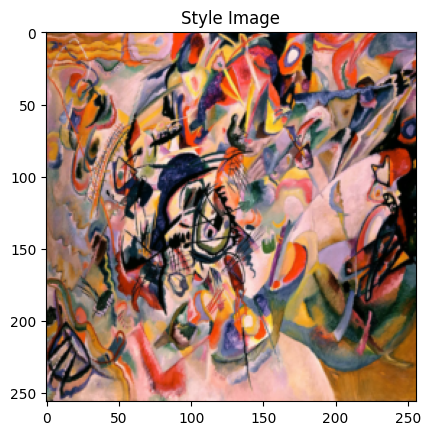

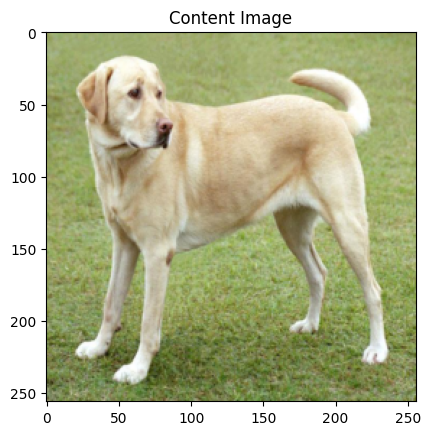

In [6]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone() 
    image = image.squeeze(0)   
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## 3. Loss Functions

### 3.1 Content Loss

In [7]:
content_weight = 1
ContentLoss = nn.CosineSimilarity()

### 3.2 Style Loss

In [8]:
def gram_matrix(tensor):
    a, b, c, d = tensor.size()
    tensor = tensor.view(a * b, c * d)
    G = torch.mm(tensor, tensor.t())
    return G.div(a * b * c * d)

style_weight = 1e6
StyleLoss = nn.MSELoss()

## 3. Model

In [9]:
from torchvision.models import vgg19, VGG19_Weights

VGG19_pretrained = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()
for param in VGG19_pretrained.parameters():
    param.requires_grad_(False)

VGG19_pretrained.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [10]:
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [11]:
def get_features(pretrained_model, image):
    layers = {
        '0': 'conv_1',
        '5': 'conv_2',
        '10': 'conv_3',
        '19': 'conv_4',
        '28': 'conv_5'
    }
    features = {}
    x = image
    for name, pretrained_layer in pretrained_model._modules.items():
        x = pretrained_layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

In [12]:
style_features = get_features(VGG19_pretrained, style_img)

## 4. Training

In [13]:
import torch.optim as optim

target_img = content_img.clone().requires_grad_(True).to(device)
optimizer = optim.Adam([target_img], lr=0.02)

In [14]:
STEPS = 2000

for step in range(STEPS):
    optimizer.zero_grad()
    content_loss = 1.0 - ContentLoss(content_img, target_img).mean()    

    style_loss = 0
    target_features = get_features(VGG19_pretrained, target_img)
    for layer in style_layers: 
        target_gram = gram_matrix(target_features[layer])
        style_gram = gram_matrix(style_features[layer])
        style_loss += StyleLoss(style_gram, target_gram)

    total_loss = content_loss*content_weight + style_loss*style_weight
    total_loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        target_img.clamp_(0, 1)
    
    if step % 100 == 0:
        print(f"Epoch [{step+1}/{STEPS}] total loss: {total_loss.item():.8f}")
        
        fname = '3.UsingInputforContent_Cosine/at_%d.png' % (step+1)
        print(target_img[0].detach().cpu().permute(1, 2, 0).numpy().shape)
        mpl.image.imsave(fname, target_img[0].detach().cpu().permute(1, 2, 0).numpy())

Epoch [1/2000] total loss: 58.09507370
(256, 256, 3)
Epoch [101/2000] total loss: 0.66969627
(256, 256, 3)
Epoch [201/2000] total loss: 0.41748548
(256, 256, 3)
Epoch [301/2000] total loss: 0.33713305
(256, 256, 3)
Epoch [401/2000] total loss: 0.30262935
(256, 256, 3)
Epoch [501/2000] total loss: 0.28053534
(256, 256, 3)
Epoch [601/2000] total loss: 0.30720791
(256, 256, 3)
Epoch [701/2000] total loss: 0.25284147
(256, 256, 3)
Epoch [801/2000] total loss: 0.27774370
(256, 256, 3)
Epoch [901/2000] total loss: 0.26050729
(256, 256, 3)
Epoch [1001/2000] total loss: 0.23247120
(256, 256, 3)
Epoch [1101/2000] total loss: 0.21827492
(256, 256, 3)
Epoch [1201/2000] total loss: 0.23015438
(256, 256, 3)
Epoch [1301/2000] total loss: 0.21117313
(256, 256, 3)
Epoch [1401/2000] total loss: 0.20610821
(256, 256, 3)
Epoch [1501/2000] total loss: 0.22932823
(256, 256, 3)
Epoch [1601/2000] total loss: 0.20046784
(256, 256, 3)
Epoch [1701/2000] total loss: 0.27737767
(256, 256, 3)
Epoch [1801/2000] tot

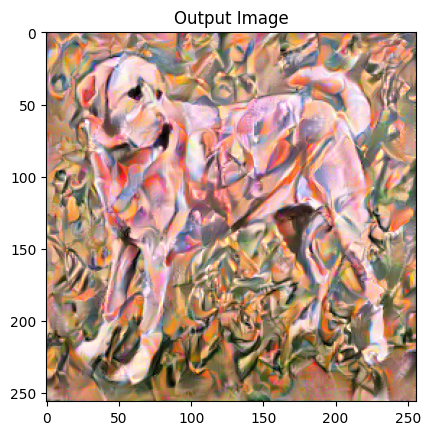

In [15]:
plt.figure()
imshow(target_img.detach(), title='Output Image')
plt.show()